# Convolutional neural network for ASL Alphabet live recognition

### Authors: Viviana Pentangelo, Ciro Maiorino

With this notebook we're going to illustrate how we have implemented and trained a Convolutional Neural Network for the recognition of the ASL Alphabet in live webcam.

The goal is to design a network that, taken as input photos representing a hand in the position of one of the gestures of the Asl Alphabet, responds with the corresponding alphabet symbol.

First, let's start by importing the necessary libraries:
* **Tensorflow** and **Keras**, for the main functions of network modeling and training.
* **Numpy**, for handling the pictures as byte arrays understandable by the network.
* **OS** and **CV2**, for the implementation of the live webcam recognition.
* **Matplotlib** for plotting pictures and graphs.


In [35]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
import tensorflow.keras

train_dir = "Dataset/asl_alphabet_train/asl_alphabet_train"
eval_dir = "Dataset/test_pics"

First, let's start by defining a function that loads the dataset into two arrays: one for the actual images and one for the true labels. </br>
We iterate through the directory dynamically constructing the path to each image. We load them and scale them from 200x200 to 64x64 pixels, and then we convert them to byte arrays.

In [30]:
def load_images(directory):
    images = []
    labels = []
    for idx, label in enumerate(uniq_labels):
        for file in os.listdir(directory + "/" + label):
            filepath = directory + "/" + label + "/" + file
            image = cv2.resize(cv2.imread(filepath), (64, 64))
            images.append(image)
            labels.append(idx)
    images = np.array(images)
    labels = np.array(labels)
    return(images, labels)

We then use the function to load the training set and test set which we will use to evaluate the model on images external from the original dataset.

In [31]:
uniq_labels = sorted(os.listdir(train_dir))

images, labels = load_images(directory = train_dir)

X_eval, y_eval = load_images(directory = eval_dir)

We then divide the training set into the actual training set and the validation set, with a proportion of 20%

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size = 0.1, stratify = labels)

n = len(uniq_labels)
train_n = len(X_train)
val_n = len(X_val)

print("Total number of symbols: ", n)
print("Number of training images: " , train_n)
print("Number of testing images: ", val_n)

eval_n = len(X_eval)
print("Number of evaluation images: ", eval_n)

Total number of symbols:  29
Number of training images:  78300
Number of testing images:  8700
Number of evaluation images:  870


We then carry out a fundamental operation, that is the one hot encoding on the labels of the dataset. </br>

This operation will make the labels suitable for use in a multi-classification problem. The output will be an array containing all 0s, except a 1 in the position corresponding to the true label of the relative pictures in the list of labels.

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]
29


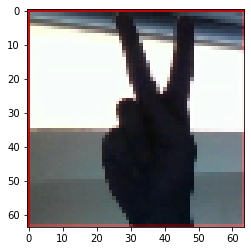

In [33]:
import tensorflow
import tensorflow.keras.utils
import matplotlib

y_train = tensorflow.keras.utils.to_categorical(y_train)
y_val = tensorflow.keras.utils.to_categorical(y_val)
y_eval = tensorflow.keras.utils.to_categorical(y_eval)

plt.imshow(X_train[0])

print(y_train[0])
print(len(y_train[0]))

As a last operation on the data, we perform the normalization of the pixel value. This operation will be repeated every time a photo is input to the network.

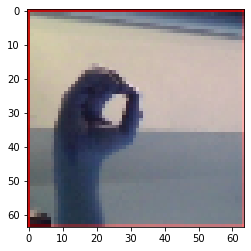

In [34]:
X_train = X_train.astype('float32')/255.0
X_val = X_val.astype('float32')/255.0
X_eval = X_eval.astype('float32')/255.0

plt.imshow(X_train[5])

Now let's proceed with the modeling of the neural network. </br>
The structure of the network provides for many layers of convolution, which apply an increasing number of filters. Instead, only two layers of pooling were used. </br>
There are two levels of dropout, with the probability set at 50%. This helps the network a lot to learn without specializing too much. </br>
Finally there is a single dense layer, with 29 neurons.

In [14]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Conv2D(filters = 64, kernel_size = 5, padding = 'same', activation = 'relu', input_shape = (64, 64, 3)))
model.add(Conv2D(filters = 64, kernel_size = 5, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (4, 4)))

model.add(Dropout(0.5))

model.add(Conv2D(filters = 128 , kernel_size = 5, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 128 , kernel_size = 5, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (4, 4)))

model.add(Dropout(0.5))

model.add(Conv2D(filters = 256 , kernel_size = 5, padding = 'same', activation = 'relu'))

model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(29, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        4864      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        102464    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       409728    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 128)         0

We compile the network and prepare it for training. </br>
The optimizer used is **Rmsprop**. </br>
RMSprop combines the idea of only using the sign of the gradient with the idea of adapting the step size individually for each weight. Unlike optimizers such as SDG, this strategy can more easily avoid getting stuck in a local minimum.</br></br>

For training, the epochs have been set to 5. The steps by epoch have not been explicitly set, so that they are auto-calculated. Batch size is 64.

In [15]:
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])

history = model.fit(X_train, y_train, epochs = 5, batch_size = 64, validation_data = (X_val, y_val))

Epoch 1/5
1102/1102 [==============================] - 607s 550ms/step - loss: 1.3223 - accuracy: 0.6043 - val_loss: 0.1513 - val_accuracy: 0.9584
Epoch 2/5
1102/1102 [==============================] - 598s 542ms/step - loss: 0.2070 - accuracy: 0.9328 - val_loss: 0.0196 - val_accuracy: 0.9946
Epoch 3/5
1102/1102 [==============================] - 580s 526ms/step - loss: 0.1289 - accuracy: 0.9614 - val_loss: 0.0073 - val_accuracy: 0.9982
Epoch 4/5
1102/1102 [==============================] - 580s 526ms/step - loss: 0.1102 - accuracy: 0.9693 - val_loss: 0.0164 - val_accuracy: 0.9941
Epoch 5/5
1102/1102 [==============================] - 579s 526ms/step - loss: 0.1008 - accuracy: 0.9741 - val_loss: 0.0055 - val_accuracy: 0.9982


We then show the training results. Validation accuracy and validation loss are always higher because of the high dropout value, but it seems like a good result. </br>
We then show the training results. The accuracy and validation loss are always higher due to the high dropout value, but the results are satisfactory. Accuracy hovers around 99%, and the loss appears to be less than 1%.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


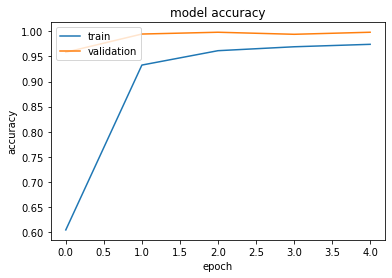

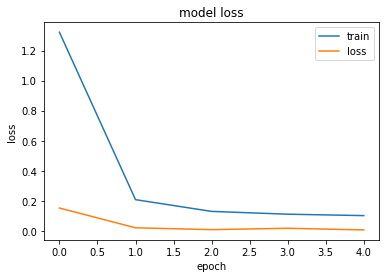

In [17]:
import matplotlib.pyplot as plt

print(history.history.keys())

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'loss'], loc = 'upper right')
plt.show()

We save the model we obtained after the training.

In [18]:
#DON'T RUN THIS AGAIN!
model.save("model2601.h5")
print("Model saved!")

Model saved!


In [3]:
model = tensorflow.keras.models.load_model("model2601.h5")
print("Model loaded!")

Model loaded!


We define a function for plotting a visual confusion matrix and have a clearer idea on how the training went.

In [19]:
def plot_confusion_matrix(y, y_pred):
    y = np.argmax(y, axis = 1)
    y_pred = np.argmax(y_pred, axis = 1)
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize = (24, 20))
    ax = plt.subplot()
    plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Purples)
    plt.colorbar()
    plt.title("Confusion Matrix")
    tick_marks = np.arange(len(uniq_labels))
    plt.xticks(tick_marks, uniq_labels, rotation=45)
    plt.yticks(tick_marks, uniq_labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    ax.title.set_fontsize(20)
    ax.xaxis.label.set_fontsize(16)
    ax.yaxis.label.set_fontsize(16)
    limit = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment = "center",color = "white" if cm[i, j] > limit else "black")
    plt.show()

We plot the matrix with the validation set, so they are still images belonging to the original dataset. Therefore, there is very little confusion in this matrix.

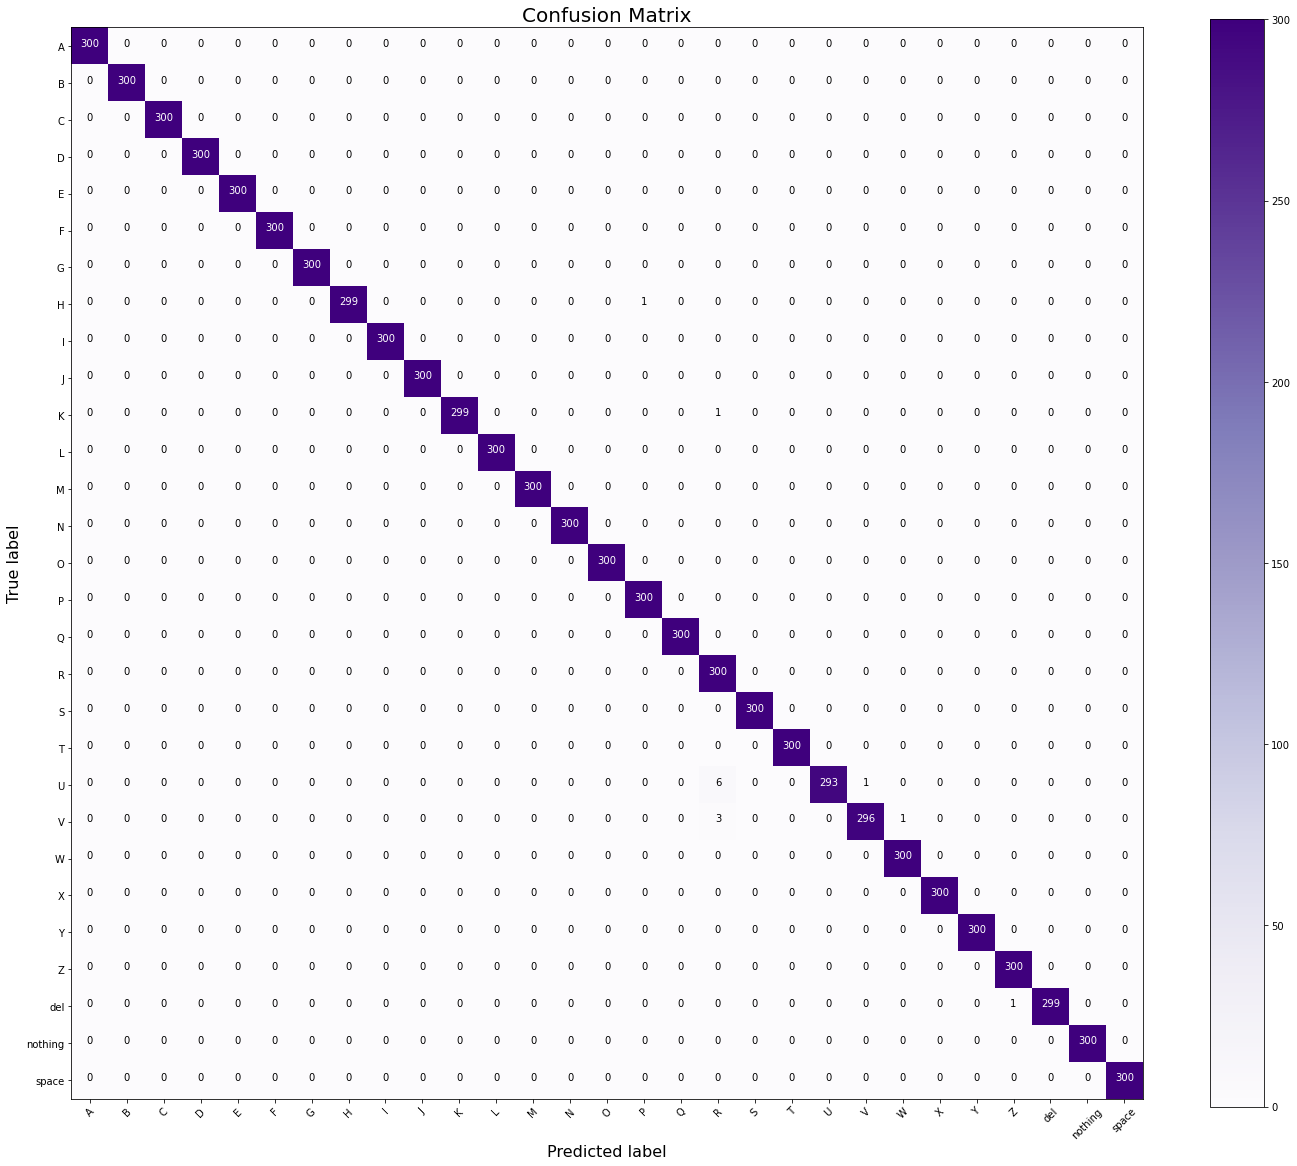

In [20]:
from sklearn.metrics import confusion_matrix
import itertools

y_test_pred = model.predict(X_val, batch_size = 64, verbose = 0)
plot_confusion_matrix(y_val, y_test_pred)

In [21]:
model.evaluate(X_val, y_val)

245/245 [==============================] - 18s 74ms/step - loss: 0.0055 - accuracy: 0.9982


[0.005479025188833475, 0.9982119798660278]

In [29]:
if uniq_labels == sorted(os.listdir(eval_dir)):
    X_eval, y_eval = load_images(directory = eval_dir)

X_eval = X_eval.astype('float32')/255.0
y_eval = tensorflow.keras.utils.to_categorical(y_eval)

print("Loaded")

Loaded


In [30]:
model.evaluate(X_eval, y_eval)

28/28 [==============================] - 2s 73ms/step - loss: 7.2225 - accuracy: 0.4414


[7.222544193267822, 0.4413793087005615]

At this point we plot the confusion matrix with a different dataset from the one used for training.</br>
Obviously, the confusion is greater than before, but all in all the network seems to have learned the right hand information for most of the classes.

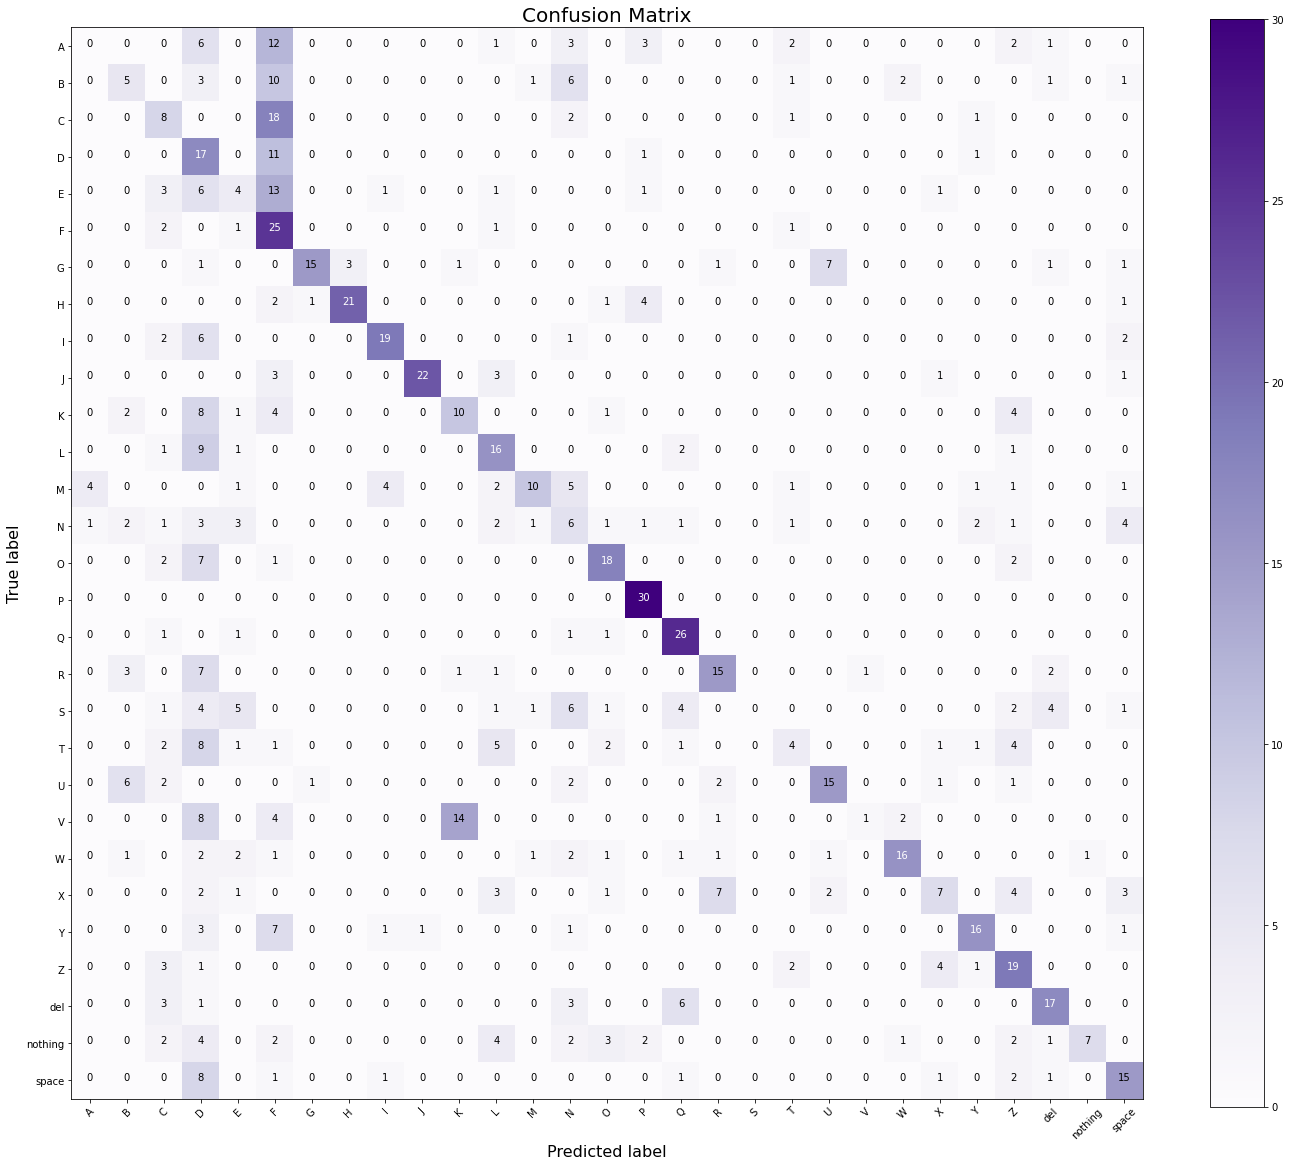

In [31]:
y_eval_pred = model.predict(X_eval, batch_size = 64, verbose = 0)
plot_confusion_matrix(y_eval, y_eval_pred)

In [26]:
if uniq_labels == sorted(os.listdir('Dataset\CiroPics')):
    X_eval, y_eval = load_images(directory = 'Dataset\CiroPics')

X_eval = X_eval.astype('float32')/255.0
y_eval = tensorflow.keras.utils.to_categorical(y_eval)

print("Loaded")

Loaded


In [27]:
model.evaluate(X_eval, y_eval)

5/5 [==============================] - 0s 58ms/step - loss: 6.7866 - accuracy: 0.5310


[6.786569595336914, 0.5310344696044922]

Last but not least, we evaluated the model on a dataset we personally built. </br>
Still, confusion is not the lowest but still good. Precision is even higher than the previous dataset and we consider it a good results. 

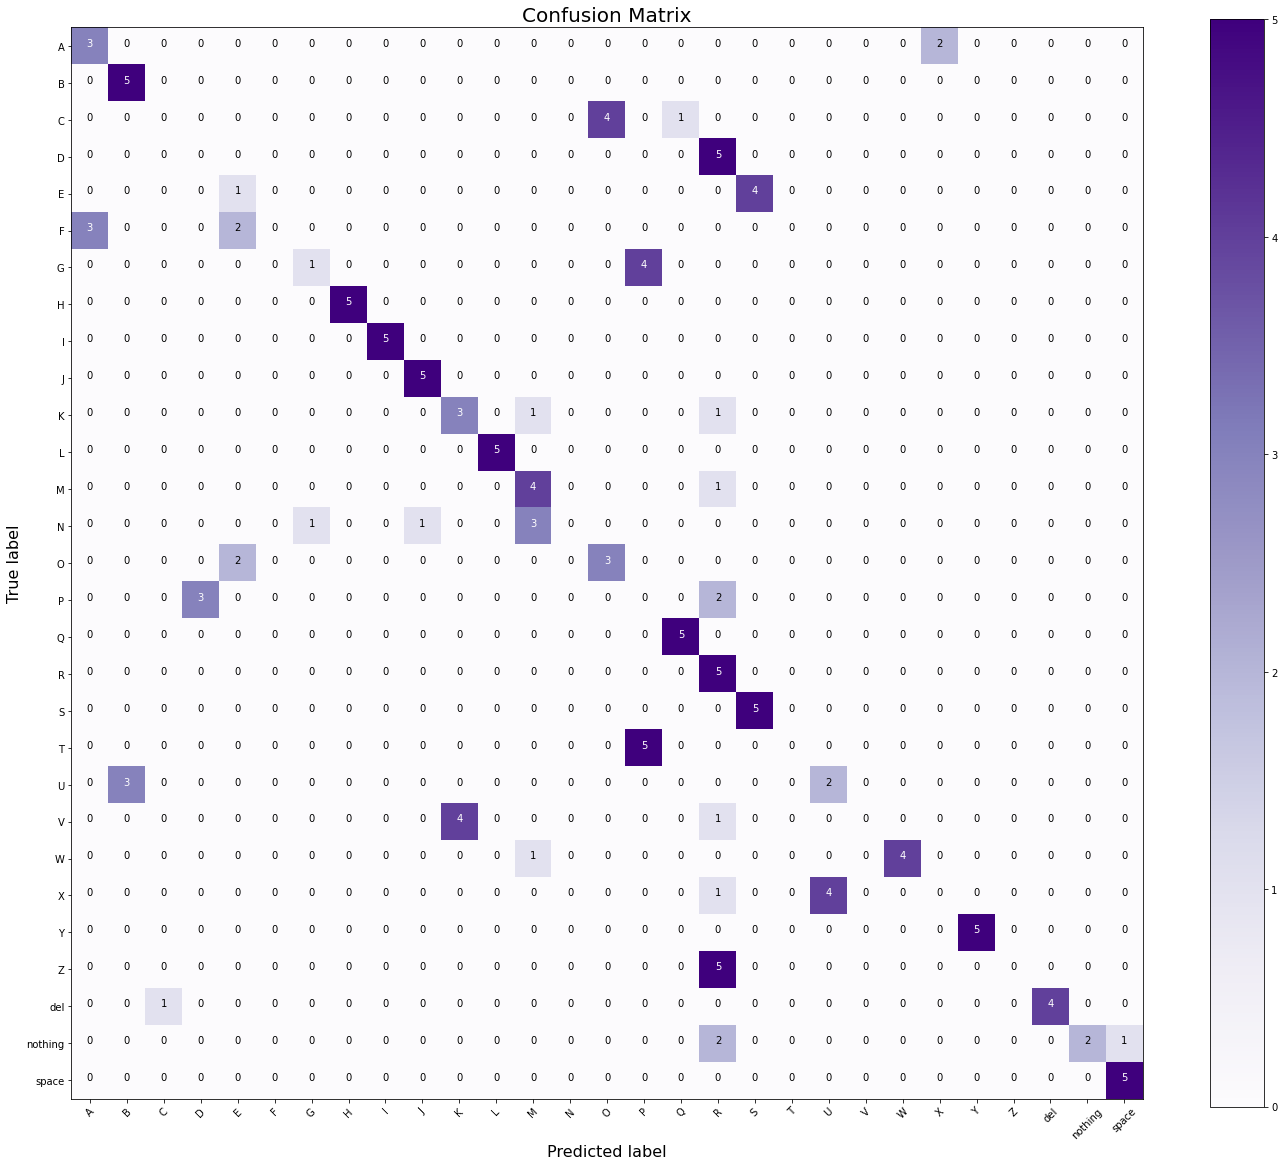

In [28]:
y_eval_pred = model.predict(X_eval, batch_size = 64, verbose = 0)
plot_confusion_matrix(y_eval, y_eval_pred)

In [4]:
def getLetter(result):
    classLabels = { 0: 'A',
                   1: 'B',
                   2: 'C',
                   3: 'D',
                   4: 'E',
                   5: 'F',
                   6: 'G',
                   7: 'H',
                   8: 'I',
                   9: 'J',
                   10: 'K',
                   11: 'L',
                   12: 'M',
                   13: 'N',
                   14: 'O',
                   15: 'P',
                   16: 'Q',
                   17: 'R',
                   18: 'S',
                   19: 'T',
                   20: 'U',
                   21: 'V',
                   22: 'W',
                   23: 'X',
                   24: 'Y',
                   25: 'Z',
                   26: 'del',
                   27: 'nothing',
                   28: 'space' }
    
    res = int(result)
    return classLabels[res]

Finally, it's time for some real time testing! </br>
Run this cell of code, making sure you have a webcam available. Place your hand in the box that appears to test the net on yourself! </br>
**To stop the session, just press the Enter key.**

In [7]:
from tensorflow.keras.preprocessing import image
from time import time
import cv2

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    
    roi = frame[100:400, 320:620]
    cv2.imshow('roi', roi)
    roi = cv2.resize(roi, (64, 64), interpolation = cv2.INTER_AREA)
    
    cv2.imshow('roi scaled', roi)
    copy = frame.copy()
    cv2.rectangle(copy, (320, 100), (620, 400), (255, 0, 0), 5)
    
    roi = roi.reshape(64, 64, 3)
    x = image.img_to_array(roi)
    x = x.astype('float32')/255.0
    x = np.expand_dims(x, axis=0)
    
    result = model.predict(x)
    letter = getLetter(np.argmax(result))
    #print(letter)
    cv2.putText(copy, letter, (300, 100), cv2.FONT_HERSHEY_COMPLEX, 2, (0, 255, 0), 2)    
    cv2.imshow('frame', copy)
    
    if cv2.waitKey(1) == 13: 
        break;

cap.release()
cv2.destroyAllWindows()

This project was developed for the **Context Aware Security Analytics** course of the Master Degree Course in **Computer Science**, at **University of Salerno**. </br>

The addressees are prof. Michele **Nappi**, prof. Fabio **Narducci** and dr. Carmen **Bisogni**.